<h1>Research Papers analytics using term frequency/document frequency</h1>
<p>In this notebook, we will explore the dataset obtain from crawling research papers</p>

In [1]:
# -*- coding: utf-8 -*-
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit
import codecs
import re
import os
from bs4 import BeautifulSoup # $ pip install beautifulsoup4
from wordcloud import WordCloud
%matplotlib inline

In [2]:
paper_df = pd.read_csv('../dataset/cleaned_papers_pdf.csv',encoding='utf-8')

In [3]:
print(paper_df.shape)
paper_df.head(10)
cleaned_papers_pdf = paper_df

(784, 5)


In [4]:
#Content2Words (or String to words seperate by space)
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer

def content_to_words( paper_content ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", paper_content) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))      
    paper_stop = ['cid','fig','however','respectively','used','therefore']
    stops |= set(paper_stop)
    
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops] 
    
    # 5. Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    meaningful_words = [wordnet_lemmatizer.lemmatize(w) for w in meaningful_words if len(w)!=1 or w in['a','i','u']]
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   
words = content_to_words('testing to convert and also cleaning. Yeah') 

In [5]:
#Cleaning all of the content csv
start = timeit.default_timer()
cleaned_papers_pdf['cleaned_content'] = cleaned_papers_pdf['content'].apply(content_to_words)
stop = timeit.default_timer()
print("Execution time : "+str(round(stop - start,2))+"s.")    

Execution time : 16.8s.


In [6]:
#Creating Bags of Words
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
tfidf_vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 10000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
tfidf_train_features = tfidf_vectorizer.fit_transform(cleaned_papers_pdf['cleaned_content'])
print("tf-idf features created")

Creating the bag of words...

tf-idf features created


In [7]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=450, random_state=42)
reduced_X = svd.fit_transform(tfidf_train_features) 

In [8]:
print(svd.explained_variance_ratio_)

[ 0.00776458  0.0153434 ]


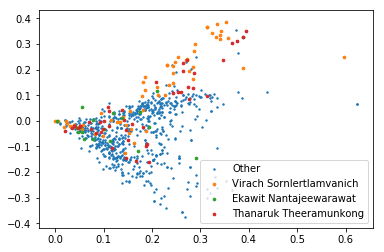

In [9]:
# get the indices where data is 1
def focus_professor(names):
    
    isnOwner = reduced_X[cleaned_papers_pdf['name'].apply(lambda x: x not in names)]
    x,y = isnOwner.T
    plt.scatter(x,y,s=2,label='Other')

    for name in names:
        isOwner = reduced_X[cleaned_papers_pdf['name'].apply(lambda x: name in x)]
        x,y = isOwner.T
        plt.scatter(x,y,s=7,label=name)
    plt.legend()
    plt.show()
focus_professor(['Virach Sornlertlamvanich','Ekawit Nantajeewarawat','Thanaruk Theeramunkong'])

<p>Note that the x and y axis has no real meaning. Each dot represent one paper. And we assume that if two dot are near to each others, they tend to be similar.</p>

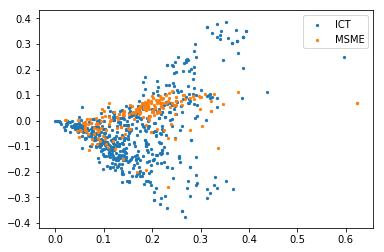

In [10]:
ICT_Professors = reduced_X[cleaned_papers_pdf['faculty']=='ICT_professor'] 
x,y = ICT_Professors.T
plt.scatter(x,y,s=5,label='ICT')
MSME_Professors = reduced_X[cleaned_papers_pdf['faculty']=='MSME']
x,y = MSME_Professors.T
plt.scatter(x,y,s=5,label='MSME')
plt.legend()
plt.show()

In [11]:
#Doing Cluster to 10 group.
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=10, random_state=0).fit(tfidf_train_features)

In [12]:
cleaned_papers_pdf['cluster'] = kmeans.labels_

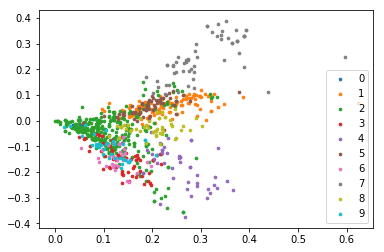

In [13]:
# get the indices where data is 1
def PCA_scatter_plot(seperator='cluster'):
    labels = set(cleaned_papers_pdf[seperator])
    for label in labels:
        isIncluded = reduced_X[cleaned_papers_pdf[seperator].apply(lambda x: x==label)]
        x,y = isIncluded.T
        plt.scatter(x,y,s=7,label=label)
    plt.legend()
    plt.show()
PCA_scatter_plot()

In [14]:
cleaned_papers_pdf[cleaned_papers_pdf['cluster']==0]

,name,content,directory,isValid,faculty,cleaned_content,cluster
477,Thanaruk Theeramunkong,vii viii ix TableofContents ParticipationinLan...,../papers/ICT_professor/Thanaruk Theeramunkong...,True,ICT_professor,vii viii ix tableofcontents participationinlan...,0
478,Thanaruk Theeramunkong,ii iii v TableofContents KnowledgeandReasoning...,../papers/ICT_professor/Thanaruk Theeramunkong...,True,ICT_professor,ii iii tableofcontents knowledgeandreasoningfo...,0
479,Thanaruk Theeramunkong,vii viii ix TableofContents ParticipationinLan...,../papers/ICT_professor/Thanaruk Theeramunkong...,True,ICT_professor,vii viii ix tableofcontents participationinlan...,0
480,Thanaruk Theeramunkong,ii iii v TableofContents KnowledgeandReasoning...,../papers/ICT_professor/Thanaruk Theeramunkong...,True,ICT_professor,ii iii tableofcontents knowledgeandreasoningfo...,0
481,Thanaruk Theeramunkong,ii iii v TableofContents KnowledgeandReasoning...,../papers/ICT_professor/Thanaruk Theeramunkong...,True,ICT_professor,ii iii tableofcontents knowledgeandreasoningfo...,0
482,Thanaruk Theeramunkong,vii viii ix TableofContents ParticipationinLan...,../papers/ICT_professor/Thanaruk Theeramunkong...,True,ICT_professor,vii viii ix tableofcontents participationinlan...,0
550,Virach Sornlertlamvanich,ii iii v TableofContents EnhancingtheJapaneseW...,../papers/ICT_professor/Virach Sornlertlamvani...,True,ICT_professor,ii iii tableofcontents enhancingthejapanesewor...,0
552,Virach Sornlertlamvanich,vii viii ix xi TableofContents ReportofNEWS201...,../papers/ICT_professor/Virach Sornlertlamvani...,True,ICT_professor,vii viii ix xi tableofcontents reportofnews ma...,0
558,Virach Sornlertlamvanich,ii iii v TableofContents EnhancingtheJapaneseW...,../papers/ICT_professor/Virach Sornlertlamvani...,True,ICT_professor,ii iii tableofcontents enhancingthejapanesewor...,0


In [15]:
cleaned_papers_pdf['cluster'].value_counts()

2    310
1    117
5     62
3     60
7     59
8     53
4     46
9     34
6     34
0      9
Name: cluster, dtype: int64

In [16]:
freqs = [(word, tfidf_train_features.getcol(idx).sum()) for word, idx in tfidf_vectorizer.vocabulary_.items()]
#sort from largest to smallest
print(sorted(freqs, key = lambda x: -x[1])[0:40])

[('pp', 23.299282891812126), ('figure', 19.854824659943638), ('image', 19.038721236961749), ('system', 18.23242698854607), ('vol', 17.33991619835799), ('table', 15.679986977413638), ('word', 13.950782413718539), ('time', 13.562656470581018), ('data', 12.572428298700979), ('energy', 12.33339304632768), ('model', 12.328845239128754), ('let', 11.948451398016397), ('based', 11.575356881366311), ('page', 11.152380344703305), ('co', 10.955945684039055), ('method', 10.638005821108575), ('thai', 10.624349113213599), ('result', 10.545603980549597), ('algorithm', 10.529360832032831), ('max', 10.166103404454503), ('using', 9.8663794341061664), ('thailand', 9.5535773164918432), ('set', 9.3503169928342587), ('user', 9.1972836071064155), ('cost', 9.1612767107476127), ('example', 9.1367471346736142), ('number', 9.0138181885310704), ('process', 8.9861174748501611), ('ij', 8.9225735038707175), ('information', 8.626379888407774), ('value', 8.5989216886084758), ('th', 8.4925279200078307), ('etal', 8.2891

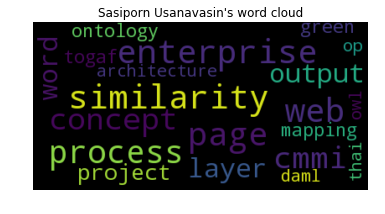

In [17]:
from wordcloud import WordCloud
def professor_wordCloud(name):
    vec_sum = np.array(tfidf_train_features.shape[1]*[0])
    professor_pdf = cleaned_papers_pdf[cleaned_papers_pdf['name']==name]
    rowNum = []
    for i,row in professor_pdf.iterrows():
        vec_sum+=tfidf_train_features.getrow(i)
        rowNum.append(i)
    word_tfidf_vector = vec_sum.tolist()[0]
    sorted_vector_index = sorted(range(len(word_tfidf_vector)), key=lambda k: -word_tfidf_vector[k])
    features_names = tfidf_vectorizer.get_feature_names()
    wordCloudText =''
    j=1000
    for i in sorted_vector_index[0:20]:
        if(len(features_names[i])<15):
            wordCloudText+=features_names[i]+" "
    wordcloud = WordCloud(max_font_size=40).generate(wordCloudText)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(name+"'s word cloud")
    plt.show()
    
professor_wordCloud('Sasiporn Usanavasin')

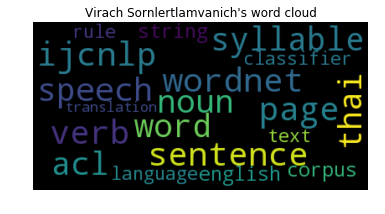

In [18]:
professor_wordCloud('Virach Sornlertlamvanich')

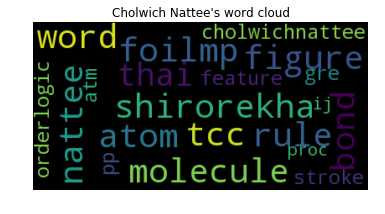

In [19]:
professor_wordCloud('Cholwich Nattee')

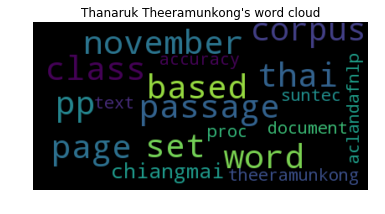

In [20]:
professor_wordCloud('Thanaruk Theeramunkong')

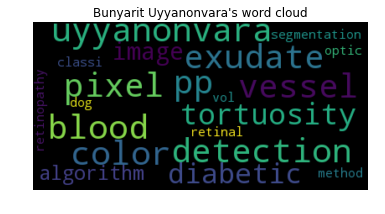

In [21]:
#cleaned_papers_pdf['name'].value_counts()
professor_wordCloud('Bunyarit Uyyanonvara')